<a href="https://colab.research.google.com/github/break-pointt/camera_calibration/blob/master/traffic_sign_recognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


#Traffic sign detection using YOLO
## get the data:
- [X] select data set
- [X] resize code for images and annotations
## data Feader:
- [X] create Data Augmentation pipline
- [X] store the images and labels on local disc
- [X] create a data loader that will take a portion of data and feed it into 
model
## Model:
- [X] prepare the model in Keras
- [ ] create helper classes for IOU calculation
- [X] create loss function
- [x] create optimizer
## train the model
- [ ] use pre-trained weights for our model
- [ ] train on specific label.

In [ ]:
%%capture
!pip install openimages
!pip install albumentations
!pip uninstall tensorflow -y
!pip install tensorflow-gpu==2.2.1

In [ ]:
from PIL import Image
import numpy as np
import cv2
import matplotlib.pyplot as plt
import csv
import os
import tensorflow as tf
from tensorflow import keras
import tensorflow.keras.backend as K
from tensorflow.keras.layers import Conv2D,MaxPooling2D,GlobalMaxPooling2D,Dense,InputLayer, Dropout, Flatten, Reshape
from tensorflow.keras.utils import Sequence
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn.model_selection import train_test_split
import random as rand
import albumentations as A
import gc

In [ ]:
#global variables
maxsize = [448,448,3]
yoloGrid = [28,28,5]
batch_size = 32


# dataset setting
dataset_dir = '/content/dataset'
csv_dir = '/content/csv'
classes = ['Traffic sign']
label_format = ['darknet','pascal']

## Getting the data

In [ ]:
# download data
if not os.path.exists('/content/TrainIJCNN2013.zip'):
    !wget https://sid.erda.dk/public/archives/ff17dc924eba88d5d01a807357d6614c/TrainIJCNN2013.zip

# if not os.path.exists('/content/dataset'):
#     download_dataset(dest_dir=dataset_dir,class_labels=classes,annotation_format=label_format[0],csv_dir=csv_dir,limit=5000)

In [ ]:
%%capture
if not os.path.exists('/content/TrainIJCNN2013'):
    !unzip  /content/TrainIJCNN2013.zip

In [ ]:
!rm -rf /content/sample_data
if os.path.exists('/content/train'):
    pass
else:
    !mkdir /content/train

In [ ]:
labelPath = '/content/TrainIJCNN2013/gt.txt'
annotationfile = '/content/trainLabels.txt'
with open(annotationfile, 'w') as a:
    with open(labelPath, 'r') as f:
        reader = csv.reader(f, delimiter=";")
        fileName = ""
        firstEntry = True
        for entry in reader:
            if entry[0] == fileName:
                x1, y1, x2, y2 = entry[1:5]
                a.write(' %s;%s;%s;%s' % (x1, y1, x2, y2))
            else:
                fileName = entry[0]
                if firstEntry:
                    firstEntry = False
                else:
                    a.write('\n')
                a.write(fileName+" ")
                x1, y1, x2, y2 = entry[1:5]
                a.write('%s;%s;%s;%s' % (x1, y1, x2, y2))

## annotation resizing
lets take an image of size $m*n$. resize it to a size of $p*q$. to resize the annotations (if they are in terms of pixel not ratios). $\frac{p}{m}*(x_1,x_2)$ and $\frac{q}{n}*(y_1,y_2)$ will give us new annotation coordinates.

In [ ]:
def resize_image(imgPath):
    # load the image
    img = cv2.imread(imgPath)
    # original image size
    n,m = img.shape[0:2]
    #resize image
    img = cv2.resize(img,tuple(maxsize[0:2]))
    # covert to numpy array
    # img = np.array(img,dtype='int16')
    # save new image sizes
    p,q = img.shape[0:2]
    # calculate the scaling factor
    x_scale = float(p/m)
    y_scale = float(q/n)
    # calculate new annotation coordinates
    # return objects
    return img,{'x_scale':x_scale,'y_scale':y_scale}


def resize_annotations(values,box):
    # corrdinates
    x1,y1,x2,y2 = box
    # retrieve the scaling factor
    x_scale = values['x_scale']
    y_scale = values['y_scale']
    # calculate new annotation coordinates
    x1,x2 = int(x_scale*x1),int(x_scale*x2)
    y1,y2 = int(y_scale*y1),int(y_scale*y2)
    # return objects
    return x1,y1,x2,y2

def resizeAnnotations(values,box):
    # corrdinates
    x,y,w,h = box
    # retrieve the scaling factor
    x_scale = values['x_scale']
    y_scale = values['y_scale']
    # calculate new annotation coordinates
    x,w = x_scale*x,x_scale*w
    y,h = y_scale*y,y_scale*h
    # return objects
    return x,y,w,h

## Data Augmentation

In [ ]:
def makeSunny(image):
    image_copy = image.copy()
    image_HLS = cv2.cvtColor(image_copy,cv2.COLOR_RGB2HLS) ## Conversion to HLS
    image_HLS = np.array(image_HLS, dtype = np.float64)
    random_brightness_coefficient = 1.5
    image_HLS[:,:,1] = image_HLS[:,:,1]*random_brightness_coefficient ## scale pixel values
    image_HLS[:,:,1][image_HLS[:,:,1]>255]  = 255 ##Sets all values above 255 to 255
    image_HLS = np.array(image_HLS, dtype = np.uint8)
    image_RGB = cv2.cvtColor(image_HLS,cv2.COLOR_HLS2RGB) ## Conversion to RGB
    return image_RGB

In [ ]:
def makeShady(image):
    image_copy = image.copy()
    image_HLS = cv2.cvtColor(image_copy,cv2.COLOR_RGB2HLS) ## Conversion to HLS
    image_HLS = np.array(image_HLS, dtype = np.float64)
    random_brightness_coefficient = 0.5
    image_HLS[:,:,1] = image_HLS[:,:,1]*random_brightness_coefficient ## scale pixel values
    image_HLS[:,:,1][image_HLS[:,:,1]>255]  = 255 ##Sets all values above 255 to 255
    image_HLS = np.array(image_HLS, dtype = np.uint8)
    image_RGB = cv2.cvtColor(image_HLS,cv2.COLOR_HLS2RGB) ## Conversion to RGB
    return image_RGB

In [ ]:
def addSnow(image):
    image_copy = image.copy()
    image_HLS = cv2.cvtColor(image_copy,cv2.COLOR_RGB2HLS) ## Conversion to HLS
    image_HLS = np.array(image_HLS, dtype = np.float64)
    brightness_coefficient = 2.5
    snow_point=140 ## increase this for more snow 
    image_HLS[:,:,1][image_HLS[:,:,1]<snow_point] = image_HLS[:,:,1][image_HLS[:,:,1]<snow_point]*brightness_coefficient ## scale pixel values up for channel 1(Lightness)
    image_HLS[:,:,1][image_HLS[:,:,1]>255]  = 255 ##Sets all values above 255 to 255
    image_HLS = np.array(image_HLS, dtype = np.uint8)
    image_RGB = cv2.cvtColor(image_HLS,cv2.COLOR_HLS2RGB) ## Conversion to RGB
    return image_RGB

In [ ]:
def generate_random_lines(imshape,slant,drop_length):
    drops=[]
    for i in range(1500): ## If You want heavy rain, try increasing this
        if slant<0:
            x= np.random.randint(slant,imshape[1])
        else:
            x= np.random.randint(0,imshape[1]-slant)
        y= np.random.randint(0,imshape[0]-drop_length)
        drops.append((x,y))
    return drops


def addRain(image):
    image_copy = image.copy()
    imshape = image_copy.shape
    slant_extreme=10
    slant= np.random.randint(-slant_extreme,slant_extreme)
    drop_length=20
    drop_width=2
    drop_color=(200,200,200) ## a shade of gray
    rain_drops= generate_random_lines(imshape,slant,drop_length)
    for rain_drop in rain_drops:
        cv2.line(image_copy,(rain_drop[0],rain_drop[1]),(rain_drop[0]+slant,rain_drop[1]+drop_length),drop_color,drop_width)
    image_copy= cv2.blur(image_copy,(7,7)) ## rainy view are blurry 
    brightness_coefficient = 0.8 ## rainy days are usually shady
    image_HLS = cv2.cvtColor(image_copy,cv2.COLOR_RGB2HLS) ## Conversion to HLS
    image_HLS[:,:,1] = image_HLS[:,:,1]*brightness_coefficient ## scale pixel values down for channel 1(Lightness)
    image_RGB = cv2.cvtColor(image_HLS,cv2.COLOR_HLS2RGB) ## Conversion to RGB
    return image_RGB

In [ ]:
def addMotionBlur(image):
    image_copy = image.copy()
    motionBlurer = A.MotionBlur((25,25),p=1)
    bluredImage = motionBlurer(image = image_copy)
    return bluredImage['image']

In [ ]:
def addNoise(image):
    image_copy = image.copy()
    noiseAdder = A.GaussNoise(var_limit=(25,100),always_apply=True,p=1)
    noiseImage = noiseAdder(image = image_copy)
    return noiseImage['image']

In [ ]:
def addColorShift(image):
    image_copy = image.copy()
    colorShifter = A.RGBShift(r_shift_limit=25,b_shift_limit=25,g_shift_limit=25,always_apply=True,p=1)
    coloredImage = colorShifter(image = image_copy)
    return coloredImage['image']

In [ ]:
def addRandomChannelShift(image):
    image_copy = image.copy()
    channelShuffler = A.ChannelShuffle(p=1)
    shuffledImage = channelShuffler(image = image_copy)
    return shuffledImage['image']

### Generate data

In [ ]:
## GTSDB
def generateData():
    with open('/content/annotation_cross_checking.txt','w') as f:  
        with open(annotationfile,'r') as a:
            reader = csv.reader(a, delimiter=" ")
            firstEntry = True
            for entry in reader:
                fileName = entry[0]
                imgpath = '/content/TrainIJCNN2013/%s'%(fileName)
                originaImage, values = resize_image(imgpath)
                originaImage = cv2.cvtColor(originaImage,cv2.COLOR_BGR2RGB)
                n,m = originaImage.shape[0:2]

                for box in entry[1:]:
                    box = box.split(';')
                    box = map(int,box)
                    x1,y1,x2,y2 = resize_annotations(values,box)
                    #creating a zero matrix for our labels
                    label_matrix = np.zeros(yoloGrid)
                    # as per the paper the annotations are mentioned as the
                    # percentages of width and height of the image
                    x = (x1 + x2) / 2 / m
                    y = (y1 + y2) / 2 / n
                    w = (x2 - x1) / m
                    h = (y2 - y1) / n
                    loc = [yoloGrid[1] * x, yoloGrid[0] * y]
                    # figuring out in which grid box the centre will be located
                    loc_i = int(loc[1])
                    loc_j = int(loc[0])
                    # offset from the grid box (0,0) to the center
                    y = loc[1] - loc_i
                    x = loc[0] - loc_j
                    # adding the computed x,y,w,h values to the grid box
                    label_matrix[loc_i, loc_j, :] = [1,x, y, w, h]
                    number = fileName.split('.')
                    number = number[0]
                    if firstEntry:
                        f.write(number)
                        firstEntry =False
                    else:
                        f.write('\n'+number)
                    # original image
                    cv2.imwrite('/content/train/%s_original.jpg'%(number),originaImage)
                    np.save('/content/train/%s_original'%(number), label_matrix)
                    # sunny image
                    sunnyImage = makeSunny(originaImage)
                    cv2.imwrite('/content/train/%s_sunny.jpg'%(number),sunnyImage)
                    np.save('/content/train/%s_sunny'%(number), label_matrix)
                    # Shady image
                    shadyImage = makeShady(originaImage)
                    cv2.imwrite('/content/train/%s_shady.jpg'%(number),shadyImage)
                    np.save('/content/train/%s_shady'%(number), label_matrix)
                    # snow image
                    snowImage = addSnow(originaImage)
                    cv2.imwrite('/content/train/%s_snow.jpg'%(number),snowImage)
                    np.save('/content/train/%s_snow'%(number), label_matrix)
                    # rainy image
                    rainImage = addRain(originaImage)
                    cv2.imwrite('/content/train/%s_rain.jpg'%(number),rainImage)
                    np.save('/content/train/%s_rain'%(number), label_matrix)
                    # motionBlur
                    motionBlurImage = addMotionBlur(originaImage)
                    cv2.imwrite('/content/train/%s_motionBlur.jpg'%(number),motionBlurImage)
                    np.save('/content/train/%s_motionBlur'%(number), label_matrix)
                    # noise
                    noiseImage = addNoise(originaImage)
                    cv2.imwrite('/content/train/%s_noise.jpg'%(number),noiseImage)
                    np.save('/content/train/%s_noise'%(number), label_matrix)
                    #colorShift
                    colorShiftImage = addColorShift(originaImage)
                    cv2.imwrite('/content/train/%s_colorShift.jpg'%(number),colorShiftImage)
                    np.save('/content/train/%s_colorShift'%(number), label_matrix)
                    #RandomChannelShift
                    channelShiftImage = addRandomChannelShift(originaImage)
                    cv2.imwrite('/content/train/%s_randomChannelShift.jpg'%(number),channelShiftImage)
                    np.save('/content/train/%s_randomChannelShift'%(number), label_matrix)
                    f.write(' %s;%s;%s;%s;%s;%s'%(loc_i,loc_j,x,y,w,h))
                    
    gc.collect()
# generateData()

In [ ]:
def createLabels(imageDir,annotationDir,fileLocation):
    listOfFiles = os.listdir(annotationDir)
    isFirstFile = True
    with open(fileLocation,'w') as f:
        for file in listOfFiles:
            fileCopy = os.path.split(file)
            fileName = fileCopy[1]
            fileName = fileName.split('.')
            fileName = fileName[0]
            imageFilePath = "%s/%s.jpg"%(imageDir,fileName)
            annotationFilePath = "%s/%s"%(annotationDir,file)
            if isFirstFile:
                isFirstFile = False
            else:
                f.write('\n')
            f.write(imageFilePath)
            with open(annotationFilePath,'r') as j:
                reader = csv.reader(j, delimiter = ' ')
                for line in reader:
                    boxes =list(map(float,line[1:]))
                    x1,y1,w,h = boxes
                    x1,y1,w,h = round(x1,3),round(y1,3),round(w,3),round(h,3)
                    f.write(' %s %s %s %s'%(x1,y1,w,h))

00214
399 134 424 174


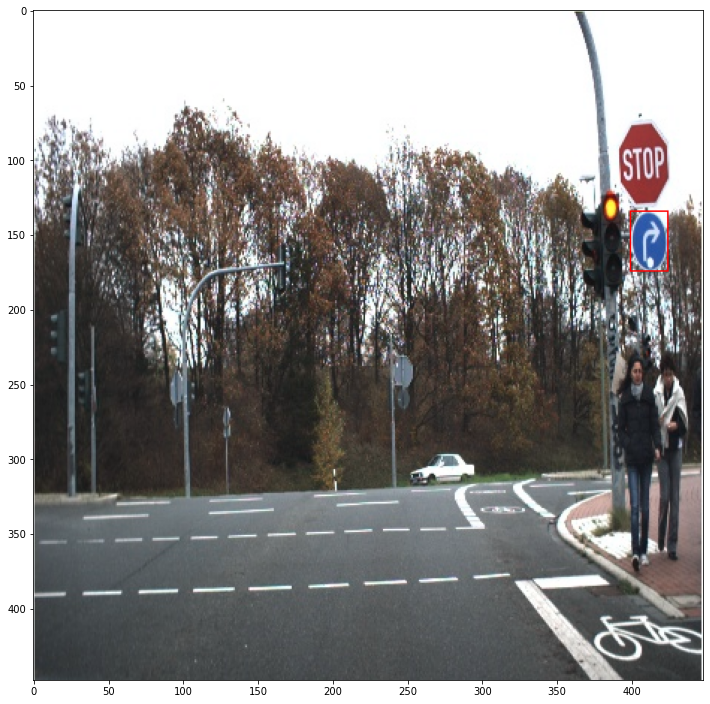

In [ ]:
# checking the annotations are correct or not.
with open('/content/annotation_cross_checking.txt','r') as f:
    reader = csv.reader(f, delimiter=" ")
    reader = list(reader)
    a = rand.randint(0,500)
    entry = reader[a]
    fileName = entry[0]
    print(fileName)
    fileName = '/content/train/%s_original.jpg'%(fileName)
    img = cv2.imread(fileName)
    ni,mi = img.shape[0:2]
    boxes = entry[1:]
    for box in boxes:
        box = box.split(';')
        i,j,xi,yi,w,h = map(float,box)
        w,h = mi*w,ni*h
        n,m = ni/yoloGrid[1],mi/yoloGrid[0]
        x = (j+xi)*m
        y = (i+yi)*n
        x1,y1 = int(round(x-w/2,3)),int(round(y-h/2,3))
        x2,y2 = int(round(x+w/2,3)),int(round(y+h/2,3))
        img = cv2.rectangle(img,(x1,y1),(x2,y2),(255,0,0),1)
        print(x1,y1,x2,y2)

plt.figure(figsize=(12,15))
plt.imshow(img)

## prepare Data for Training

In [ ]:
def randomSplitDataFromDir(dirpath,x_ext,y_ext,test_split_ratio):
    """
    This function takes a Directory path, two file extensions (one for x, one for y),
    test split ratio and retruns 4 numpy arrays in follwoing order:
    x_train,y_train, x_test, y_test
    """
    X = []
    Y = []
    dirname = dirpath
    for file in os.listdir(dirname):
        if file.endswith(x_ext):
            X.append('%s/%s'%(dirname,file))
        if file.endswith(y_ext):
            Y.append('%s/%s'%(dirname,file))
    X.sort()
    Y.sort()
    x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=test_split_ratio,
                                                        random_state=6)
    return np.array(x_train),np.array(y_train), np.array(x_test), np.array(y_test)

In [ ]:
x_train,y_train, x_test, y_test = randomSplitDataFromDir('/content/train','.jpg','.npy',0.2)

In [ ]:
x_train[587],y_train[587]

('/content/train/00216_shady.jpg', '/content/train/00216_shady.npy')

In [ ]:
class dataFeader(Sequence) :
    """
    This object takes X: a list of image file paths, Y: a list of numpy array file
    paths, a batch size and returns two numpy arrays on calling __getitem__(Idx).
    where Idx is an int. The two returned arrays are:
    an image array of size (batch_size,height,width,chanels).
    and an array of labels of size (batch_size,gridsize).
    
    note:
    gridsize is 3 dimensional.
    both X,Y are of type strings.
    
    example:
    trainDataFeeder = dataFeader(pathsToImages,pathToNumpyArrays,batch_size = 32).
    """
  
    def __init__(self, X,Y, batch_size) :
        self.X = X
        self.Y = Y
        self.batch_size = batch_size
    
    # generate the len of the batch loader
    def __len__(self) :
        return (np.ceil(len(self.X) / float(self.batch_size))).astype(np.int)
  
    # creating an itterator for the batch loader
    # this thing will be called inside a loop
    def __getitem__(self, idx) :
        batch_x = self.X[idx * self.batch_size : (idx+1) * self.batch_size]
        batch_y = self.Y[idx * self.batch_size : (idx+1) * self.batch_size]

        x = []
        y = []

        for i in range(0, len(batch_x)):
            x_path = batch_x[i]
            y_path = batch_y[i]
            x_data=  cv2.imread(x_path)
            x_data = np.array(x_data)/255
            y_data = np.load(y_path)
            x.append(x_data)
            y.append(y_data)
        
        # this will return an image array of size (batch_size,height,width,chanels)
        # and an array of labels of size (batch_size,gridsize): note gridsize is
        # 3 dimensional.
        return np.array(x), np.array(y)

In [ ]:
train_data_feader = dataFeader(x_train,y_train,batch_size=batch_size)
val_data_feader = dataFeader(x_test, y_test,batch_size=batch_size)

In [ ]:
# trail_x,trail_y = train_data_feader.__getitem__(0)
# trail_x[1]

## Model

In [ ]:
class Yolo_output(tf.keras.layers.Layer):
    def __init__(self, target_shape):
        super().__init__()
        self.target_shape = tuple(target_shape)

    def get_config(self):
        config = super().get_config().copy()
        config.update({
            'target_shape': self.target_shape
        })
        return config

    def call(self, input):
        outputs = tf.reshape(input,(-1,28,28,5))
        outputs = tf.sigmoid(outputs)

        return outputs

In [ ]:
lrelu = tf.keras.layers.LeakyReLU(alpha=0.1)

model = keras.models.Sequential(name="Trafic_Sign_detector")
#set 1
# model.add(Conv2D(filters=64, kernel_size= (3, 5), strides=(2, 2), input_shape =(maxsize[1], maxsize[0], 3), padding = 'same', activation=lrelu, kernel_regularizer=l2(5e-4)))
model.add(Conv2D(filters=64, kernel_size= (7, 7), strides=(2, 2), input_shape =(maxsize[1], maxsize[0], 3), padding = 'same', activation=lrelu, kernel_regularizer=l2(5e-4)))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding = 'same'))
#set 2
model.add(Conv2D(filters=192, kernel_size= (3, 3), padding = 'same', activation=lrelu, kernel_regularizer=l2(5e-4)))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding = 'same'))
#set 3
model.add(Conv2D(filters=128, kernel_size= (1, 1), padding = 'same', activation=lrelu, kernel_regularizer=l2(5e-4)))
model.add(Conv2D(filters=256, kernel_size= (3, 3), padding = 'same', activation=lrelu, kernel_regularizer=l2(5e-4)))
model.add(Conv2D(filters=256, kernel_size= (1, 1), padding = 'same', activation=lrelu, kernel_regularizer=l2(5e-4)))
model.add(Conv2D(filters=512, kernel_size= (3, 3), padding = 'same', activation=lrelu, kernel_regularizer=l2(5e-4)))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding = 'same'))
#set 4
#subset: repeat 4 times
model.add(Conv2D(filters=256, kernel_size= (1, 1), padding = 'same', activation=lrelu, kernel_regularizer=l2(5e-4)))
model.add(Conv2D(filters=512, kernel_size= (3, 3), padding = 'same', activation=lrelu, kernel_regularizer=l2(5e-4)))
#subset 2
model.add(Conv2D(filters=256, kernel_size= (1, 1), padding = 'same', activation=lrelu, kernel_regularizer=l2(5e-4)))
model.add(Conv2D(filters=512, kernel_size= (3, 3), padding = 'same', activation=lrelu, kernel_regularizer=l2(5e-4)))
#subset 3
model.add(Conv2D(filters=256, kernel_size= (1, 1), padding = 'same', activation=lrelu, kernel_regularizer=l2(5e-4)))
model.add(Conv2D(filters=512, kernel_size= (3, 3), padding = 'same', activation=lrelu, kernel_regularizer=l2(5e-4)))
#subset 4
model.add(Conv2D(filters=256, kernel_size= (1, 1), padding = 'same', activation=lrelu, kernel_regularizer=l2(5e-4)))
model.add(Conv2D(filters=512, kernel_size= (3, 3), padding = 'same', activation=lrelu, kernel_regularizer=l2(5e-4)))
# subset end
model.add(Conv2D(filters=512, kernel_size= (1, 1), padding = 'same', activation=lrelu, kernel_regularizer=l2(5e-4)))
model.add(Conv2D(filters=1024, kernel_size= (3, 3), padding = 'same', activation=lrelu, kernel_regularizer=l2(5e-4)))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding = 'same'))
# set 5
# subset repeat 2 times
model.add(Conv2D(filters=512, kernel_size= (1, 1), padding = 'same', activation=lrelu, kernel_regularizer=l2(5e-4)))
model.add(Conv2D(filters=1024, kernel_size= (3, 3), padding = 'same', activation=lrelu, kernel_regularizer=l2(5e-4)))
# subset 2
model.add(Conv2D(filters=512, kernel_size= (1, 1), padding = 'same', activation=lrelu, kernel_regularizer=l2(5e-4)))
model.add(Conv2D(filters=1024, kernel_size= (3, 3), padding = 'same', activation=lrelu, kernel_regularizer=l2(5e-4)))

model.add(Conv2D(filters=1024, kernel_size= (3, 3), padding = 'same', activation=lrelu, kernel_regularizer=l2(5e-4)))
model.add(Conv2D(filters=1024, kernel_size= (3, 3), strides=(2, 2), padding = 'same'))
# set 6
model.add(Conv2D(filters=1024, kernel_size= (3, 3), activation=lrelu, kernel_regularizer=l2(5e-4)))
model.add(Conv2D(filters=1024, kernel_size= (3, 3), activation=lrelu, kernel_regularizer=l2(5e-4)))

model.add(Flatten())
model.add(Dense(512))
model.add(Dense(1024))
model.add(Dropout(0.5))
model.add(Dense(np.prod(yoloGrid), activation='sigmoid'))
model.add(Yolo_output(target_shape=(yoloGrid)))
model.summary()

Model: "Trafic_Sign_detector"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 224, 224, 64)      9472      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 112, 112, 64)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 112, 112, 192)     110784    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 56, 56, 192)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 56, 56, 128)       24704     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 56, 56, 256)       295168    
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 56, 56, 25

In [ ]:
class CustomLearningRateScheduler(keras.callbacks.Callback):
    """Learning rate scheduler which sets the learning rate according to schedule.

  Arguments:
      schedule: a function that takes an epoch index
          (integer, indexed from 0) and current learning rate
          as inputs and returns a new learning rate as output (float).
  """

    def __init__(self, schedule):
        super().__init__()
        self.schedule = schedule

    def on_epoch_begin(self, epoch, logs=None):
        if not hasattr(self.model.optimizer, "lr"):
            raise ValueError('Optimizer must have a "lr" attribute.')
        # Get the current learning rate from model's optimizer.
        lr = float(K.get_value(self.model.optimizer.learning_rate))
        # Call schedule function to get the scheduled learning rate.
        scheduled_lr = self.schedule(epoch, lr)
        # Set the value back to the optimizer before this epoch starts
        tf.keras.backend.set_value(self.model.optimizer.lr, scheduled_lr)
        print("\nEpoch %i: Learning rate is %f." % (epoch, scheduled_lr))


LR_SCHEDULE = [
    # (epoch to start, learning rate) tuples
    (0, 0.01),
    (75, 0.001),
    (105, 0.0001),
]


def lr_schedule(epoch, lr):
    """Helper function to retrieve the scheduled learning rate based on epoch."""
    if epoch < LR_SCHEDULE[0][0] or epoch > LR_SCHEDULE[-1][0]:
        return lr
    for i in range(len(LR_SCHEDULE)):
        if epoch == LR_SCHEDULE[i][0]:
            return LR_SCHEDULE[i][1]
    return lr

In [ ]:
class clearModel(keras.callbacks.Callback):
    """Function that clears the variables from RAM.
    """

    def __init__(self):
        super().__init__()

    def on_epoch_end(self, epoch, logs=None):
        gc.collect()

clearTsdModel = clearModel()

## loss function

In [ ]:
def Yolo_loss(y,yHat):
    """
    This function takes true label y and predicted values y_hat and compute the loss.
    lets say we have an output like [0.5,0.25,0.48,0.22,0.54]
                       [possibility,x offset, y offset, width, height]
    will use cross-entropy loss for possibility + mean squre error for bounding boxes.
    """
    lambdaCoord = 5
    LambdaNoObj = 0.5
    objectMask = y[..., :1]
    xy = y[..., 1:3] # ture centroid values
    xyHat =yHat[..., 1:3] # predicted Centroid values
    # centroid loss
    xyLoss = lambdaCoord * tf.reduce_sum(tf.keras.losses.mean_squared_error(xy, (xyHat) * objectMask))
    wh = y[..., 3:]
    whHat = yHat[...,3:]
    ## height and width loss
    whLoss = lambdaCoord * tf.reduce_sum(tf.keras.losses.mean_squared_error(wh, (whHat) * objectMask))
    obj = y[...,:1]
    objHat = yHat[...,:1]
    bceLoss = tf.keras.losses.BinaryCrossentropy()
    # loss for not finding the object
    objLoss = bceLoss(obj,(objHat)*objectMask)
    # loss for finding false objects
    noObjLoss = LambdaNoObj* bceLoss(obj,(objHat)*(1-objectMask))

    loss = xyLoss+whLoss+objLoss+noObjLoss

    return loss


In [ ]:
y_pos_true = np.random.randint(0, 1, size=(10,28,28))
y_pos_boxes = np.random.random(size = (10,28,28,4))
y_true = np.zeros(shape=(10,28,28,5))
y_true[...,0] = y_pos_true
y_true[...,1:] = y_pos_boxes
y_pred = np.random.random(size=(10,28,28,5))

assert y_true.shape == y_pred.shape

loss = Yolo_loss(y_true,y_pred)
print(loss)

tf.Tensor(26148.45748566329, shape=(), dtype=float64)


In [ ]:
# call back for saving the weights
mcp_save = ModelCheckpoint('/content/drive/MyDrive/Colab Notebooks/work/weight.hdf5', save_best_only=True, monitor='val_loss', mode='min')

In [ ]:
# compile the model
model.compile(loss=Yolo_loss ,optimizer='adam')

In [ ]:
#load the weights
if os.path.exists('/content/drive/MyDrive/Colab Notebooks/work/weight.hdf5'):
    model.load_weights('/content/drive/MyDrive/Colab Notebooks/work/weight.hdf5')

## training

In [ ]:
# # train the model
# model.fit(train_data_feader,
#           steps_per_epoch = int(len(x_train) // batch_size),
#           epochs = 2,
#           verbose = 1,
#           workers= 4,
#           validation_data = val_data_feader,
#           validation_steps = int(len(x_test) // batch_size),
#            callbacks=[
#               CustomLearningRateScheduler(lr_schedule),
#               mcp_save,clearTsdModel
#           ])

## inferencing

In [ ]:
# input will be (1,28,28,5)
# reshape it to (28,28,5)
# supress all the boxes which has less than 0.6 probability
def predictOutput(img):
    img_copy = np.array([cv2.resize(img,(448,448))])
    output = model.predict([img_copy])
    output = np.array(output)
    finalImage = generateOuptput(output,img)
    return finalImage

def generateOuptput(output,img_copy):
    for i in range(28):
        for j in range(28):
            box = output[0,i,j,:]
            if box[0] > 0.5:
                img_copy = drawboxes(img_copy,box[1:],i,j)
                
    return img_copy
    

def drawboxes(img, box, i,j):
    ni,mi = img.shape[0:2]
    x,y,w,h = box
    n,m = ni/yoloGrid[1],mi/yoloGrid[0]
    w,h = mi*w,ni*h
    x = (j+xi)*m
    y = (i+yi)*n
    x1,y1 = int(round(x-w/2,3)),int(round(y-h/2,3))
    x2,y2 = int(round(x+w/2,3)),int(round(y+h/2,3))
    img = cv2.rectangle(img,(x1,y1),(x2,y2),(255,0,0),1)
    # print('box drawing with %i,%i,%i,%i'%(x1,x2,y1,y2))
    return  img

# def whToxy(x,y,w,h,i,j):
#     x1,x2 = ((j/28)+x)-(w/2),((j/28)+x)+(w/2)
#     y1,y2 = ((i/28)+y)-(h/2),((i/28)+y)+(h/2)
#     return x1,y1,x2,y2

(800, 1360, 3)


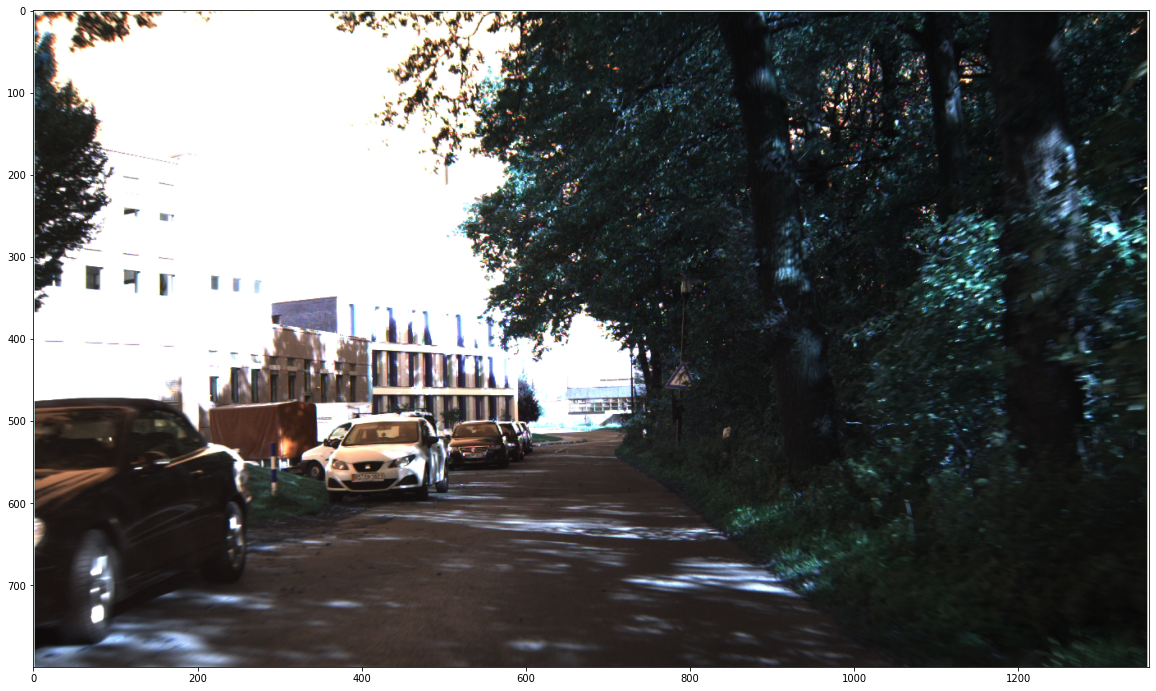

In [ ]:
image = cv2.imread('/content/TrainIJCNN2013/00015.ppm')
print(image.shape)
outputImage = predictOutput(image)
plt.figure(figsize=(20,30))
plt.imshow(outputImage)